In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt

2023-04-10 17:12:45.892803: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 17:12:45.930452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 17:12:45.931014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 17:12:46.479610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
PDBs = pickle.load(open('PDBs_RDKit.pkl', 'rb'))
df = pd.read_csv('T_data.csv')

In [3]:
%cd ../../PGGCN/

/home/ali/GBNN/PGGCN


In [4]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [5]:
from models.dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]
        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [6]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

In [7]:
X_train, X_test, y_train, y_test = X[:int(.8*len(X))], X[int(.8*len(X)):], y[:int(.8*len(X))], y[int(.8*len(X)):]
info_train, info_test = info[:int(.8*len(X))], info[int(.8*len(X)):]

In [8]:
X_c = X.copy()
y_c = y.copy()

In [15]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [21]:
import models.layers_update_mobley as layers
import importlib
# import tensorflow_addons as tfa
importlib.reload(layers)


class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', name='dense1')
#         self.dense2 = tf.keras.layers.Dense(32, activation='sigmoid')
#         self.dense3 = tf.keras.layers.Dense(100, activation='relu')
#         self.dense4 = tf.keras.layers.Dense(80, activation='relu')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
#         self.dense7 = tf.keras.layers.Dense(1, name='dense7',
#                  kernel_initializer=tf.keras.initializers.Constant([-.2, -1, 1, 1]),
#                  bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
#         agg = []
#         for i in range(len(x_a)):
#             agg.append([x_a[i], self.a_l[i]])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
#         x = self.dense2(x)
#         x = self.dense3(x)
#         x = self.dense4(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
#         merged = tf.concat([model_var, physics_info], axis=1)
#         out = self.dense7(merged)
        return model_var

m = PGGCNModel()
m.addRule("sum", 0, 31)
m.addRule("multiply", 31, 33)
m.addRule("distance", 33, 36)

import keras.backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    

# optimizers = [
#     tf.keras.optimizers.Adam(learning_rate=0.1),
#     tf.keras.optimizers.Adam(learning_rate=0.005)
# ]
# optimizers_and_layers = [(optimizers[0], m.layers[:len(m.layers) - 1]), 
#                          (optimizers[1], m.layers[len(m.layers) - 1])]    
# optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

# opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
m.compile(loss=pure_rmse, optimizer='adam')#opt)
X_train, X_test, y_train, y_test = X[:int(.8*len(X))], X[int(.8*len(X)):], y[:int(.8*len(X))], y[int(.8*len(X)):]
info_train, info_test = info[:int(.8*len(X))], info[int(.8*len(X)):]

input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
m.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 41])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = m.fit(X_train, y_train, epochs = 50, batch_size=64)

Epoch 1/50
1/1 [==============================] - 65s 65s/step - loss: 114.0008
Epoch 2/50
1/1 [==============================] - 0s 256ms/step - loss: 67.3415
Epoch 3/50
1/1 [==============================] - 1s 506ms/step - loss: 21.5069
Epoch 4/50
1/1 [==============================] - 0s 499ms/step - loss: 24.7728
Epoch 5/50
1/1 [==============================] - 0s 472ms/step - loss: 43.2476
Epoch 6/50
1/1 [==============================] - 0s 487ms/step - loss: 45.7825
Epoch 7/50
1/1 [==============================] - 1s 507ms/step - loss: 37.9580
Epoch 8/50
1/1 [==============================] - 0s 471ms/step - loss: 23.2608
Epoch 9/50
1/1 [==============================] - 0s 497ms/step - loss: 3.9960
Epoch 10/50
1/1 [==============================] - 0s 489ms/step - loss: 19.2351
Epoch 11/50
1/1 [==============================] - 0s 489ms/step - loss: 31.7480
Epoch 12/50
1/1 [==============================] - 0s 491ms/step - loss: 36.1609
Epoch 13/50
1/1 [=====================

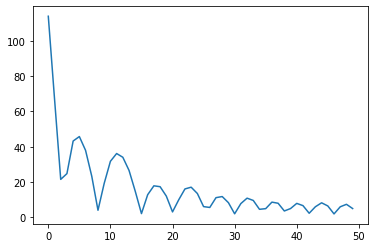

In [23]:
plt.plot(hist.history['loss'])

In [22]:
input_shapes = []
y_test = y[int(.8*len(X)):]
for i in range(len(X_test)):
    input_shapes.append(np.array(X_test[i]).shape[0])
m.set_input_shapes(input_shapes)
for i in range(len(X_test)):
    if X_test[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 41])
        X_test[i] = np.concatenate([X_test[i], new_list], 0)
X_test = np.array(X_test)
y_test = np.array(y_test)
m.evaluate(X_test, y_test)

1/1 [==============================] - 6s 6s/step - loss: 3.0139


3.013862371444702

In [24]:
with open('PGCN_DD_single.pkl', 'wb') as f:
    pickle.dump([hist.history['loss'], 3.01], f)